<a href="https://colab.research.google.com/github/itzrnvr/opencv-labs/blob/main/lab12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image Saliency, Video Saliency, K-Means, Graph Cut Segmentation

In [1]:
import cv2
import numpy as np
import imutils
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
IMG_PATH = 'fox.webp'
VIDEO_PATH = 'videoplayback.mp4'

In [3]:
img0 = cv2.cvtColor(cv2.imread(IMG_PATH), cv2.COLOR_BGR2RGB)

In [4]:
stat_sal = cv2.saliency.StaticSaliencySpectralResidual_create()

In [5]:
ok, sal_map = stat_sal.computeSaliency(img0)
sal_map = (sal_map * 255).astype(np.uint8)

In [6]:
t_map = cv2.threshold(sal_map, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

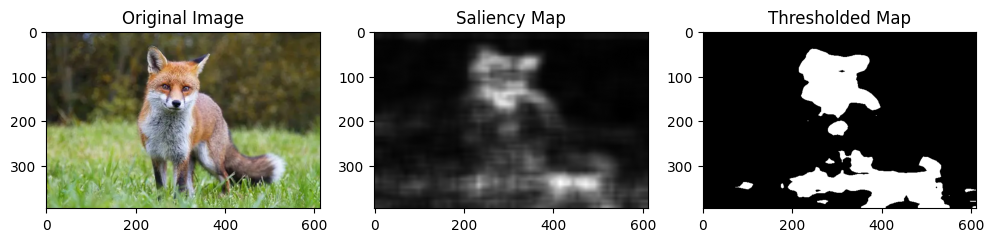

In [7]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title('Original Image'); plt.imshow(img0)
plt.subplot(1,3,2); plt.title('Saliency Map'); plt.imshow(sal_map, cmap='gray')
plt.subplot(1,3,3); plt.title('Thresholded Map'); plt.imshow(t_map, cmap='gray')
plt.show()

In [8]:
vidcap = cv2.VideoCapture(VIDEO_PATH)

In [9]:
dyn_sal = None

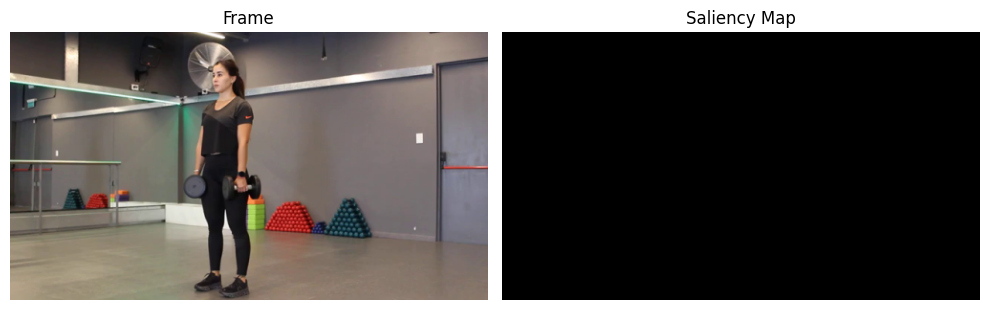

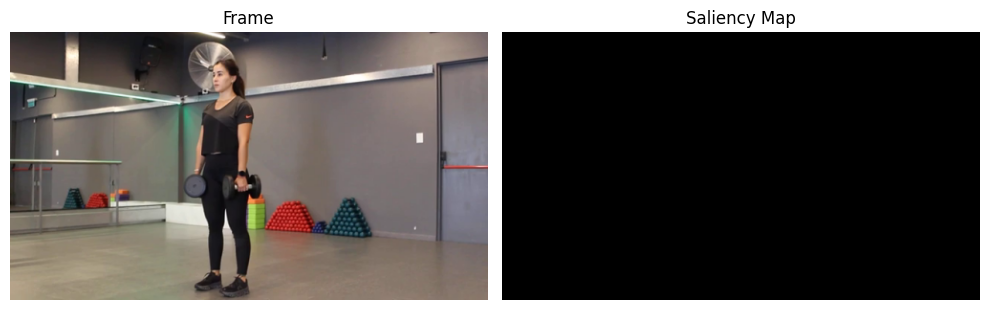

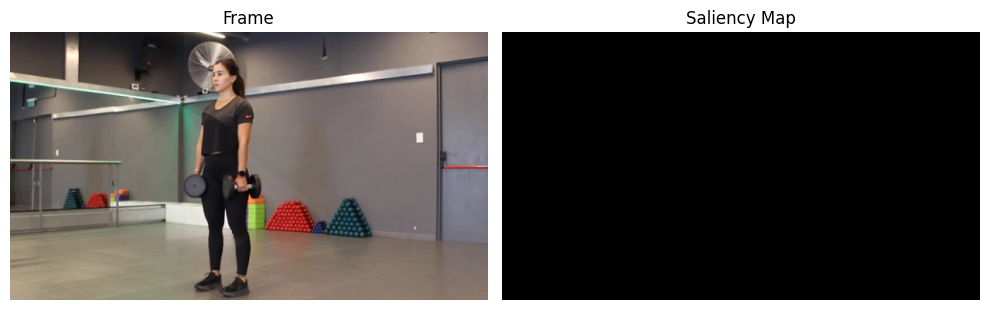

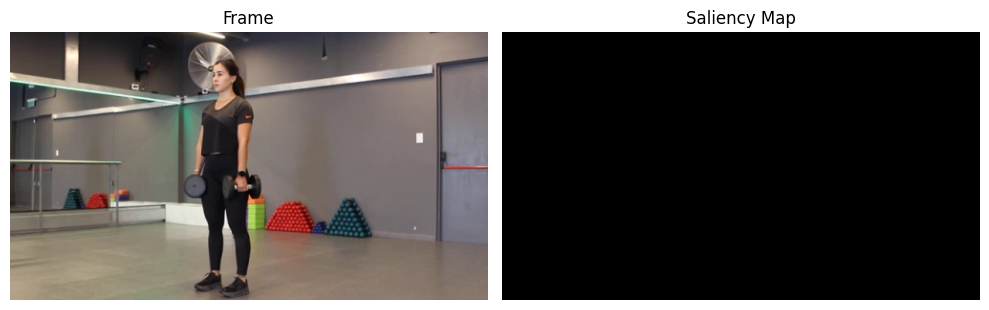

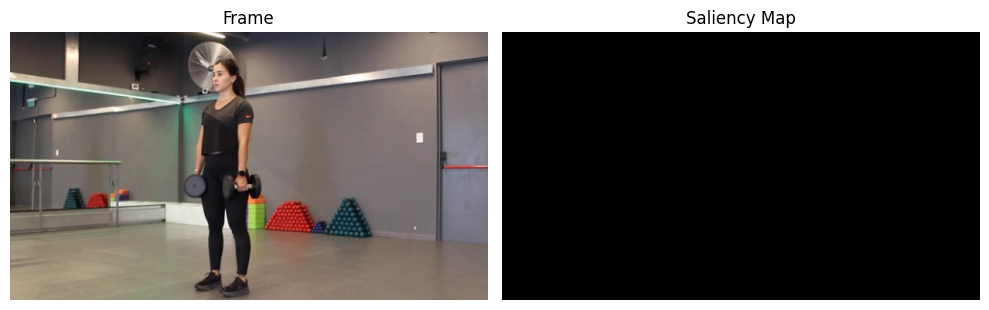

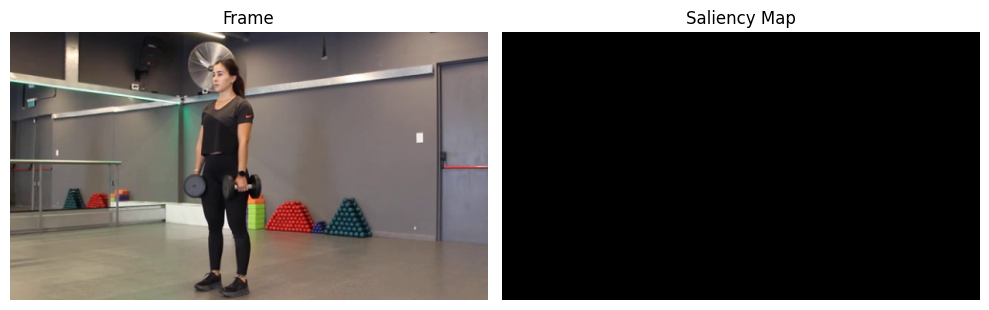

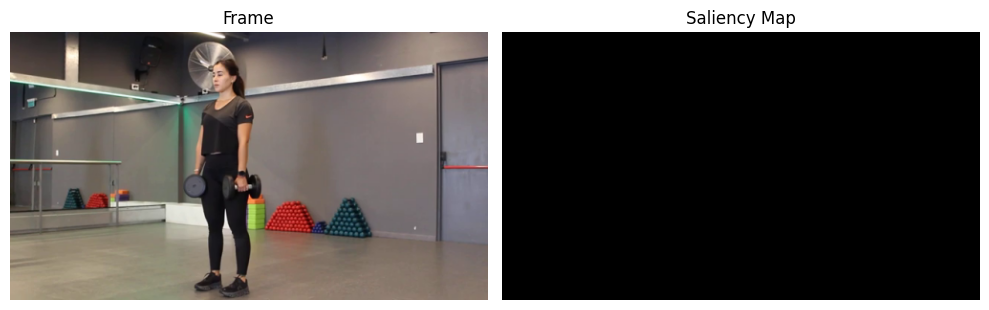

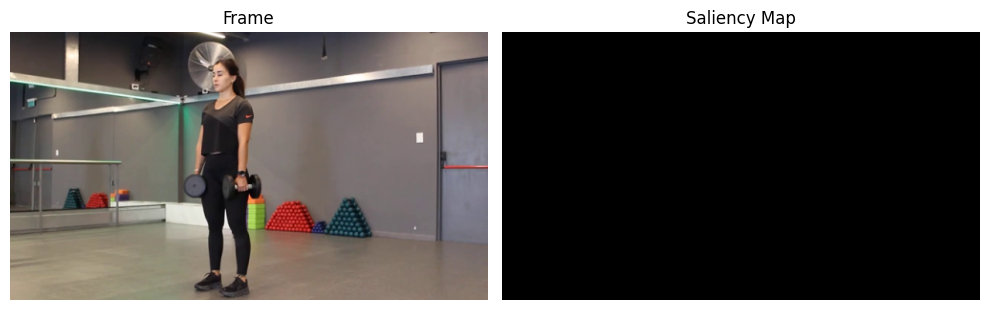

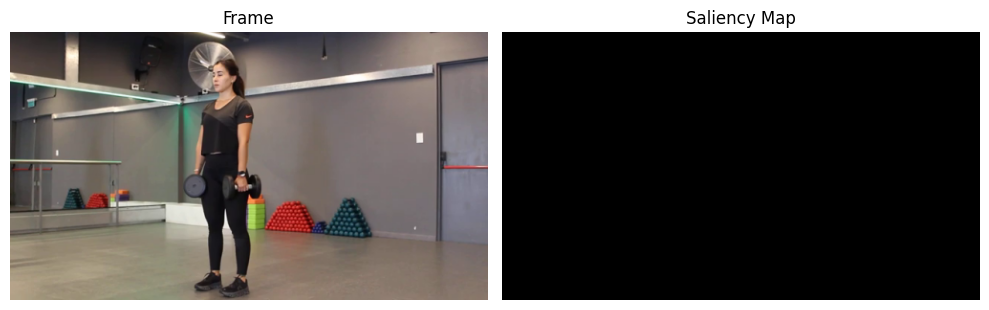

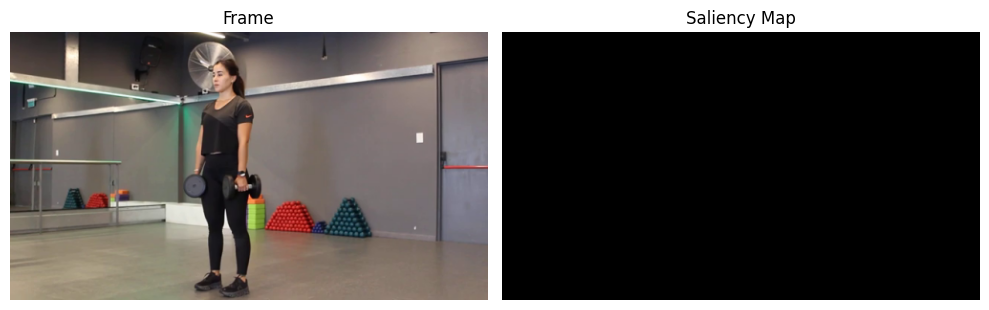

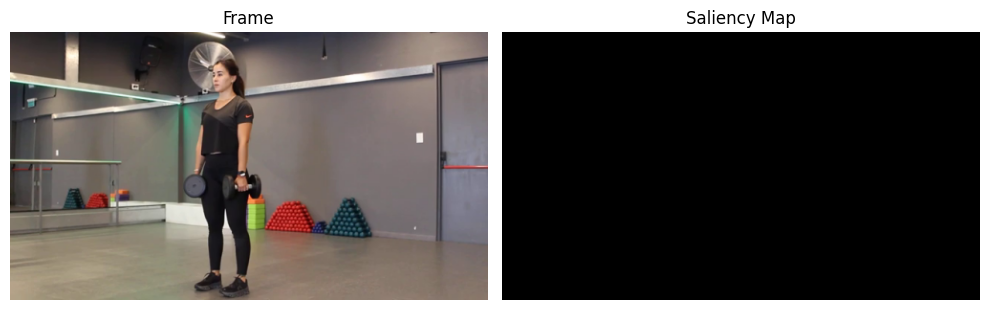

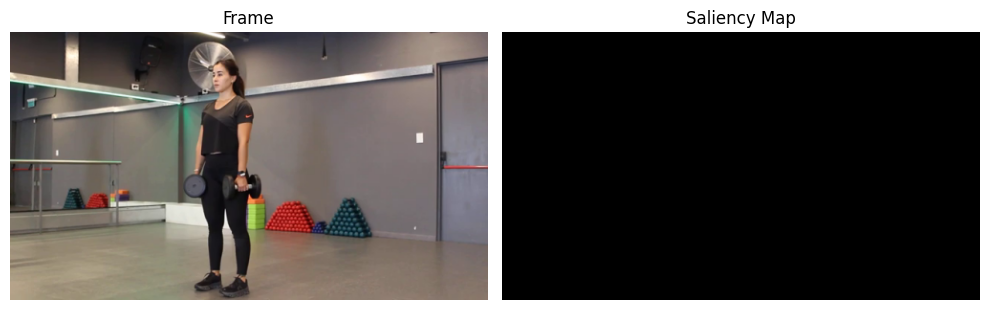

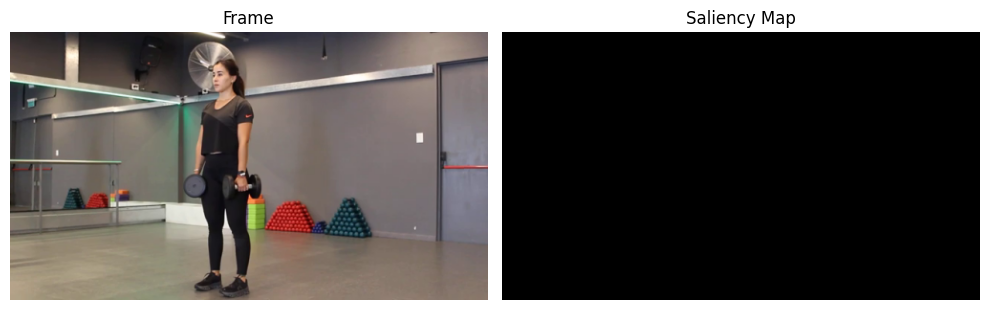

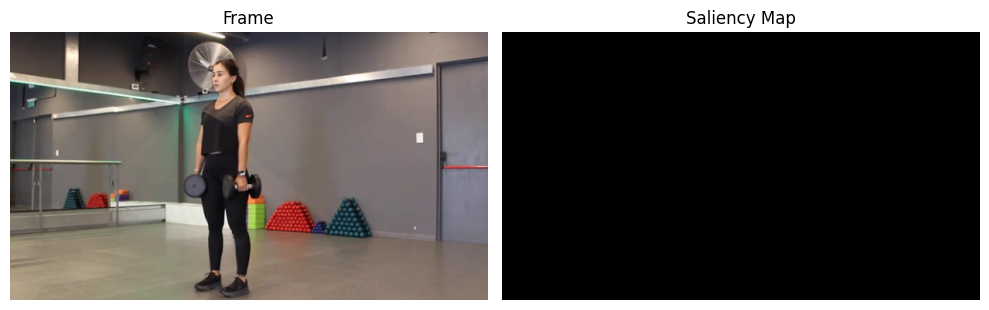

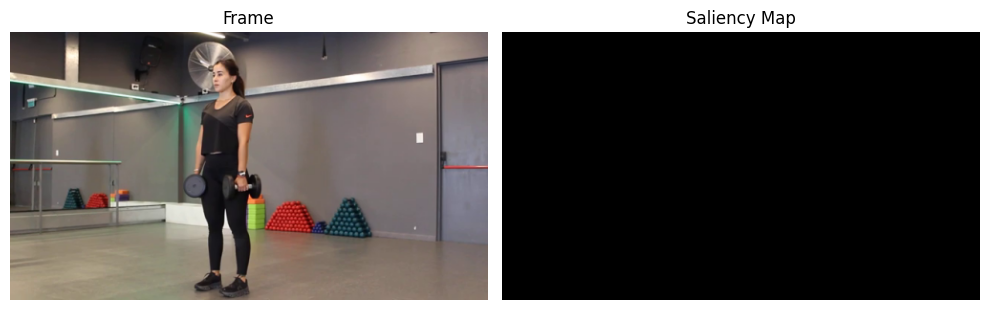

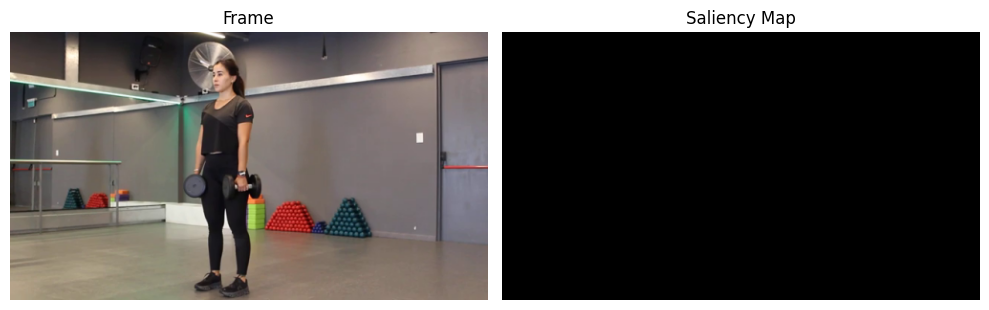

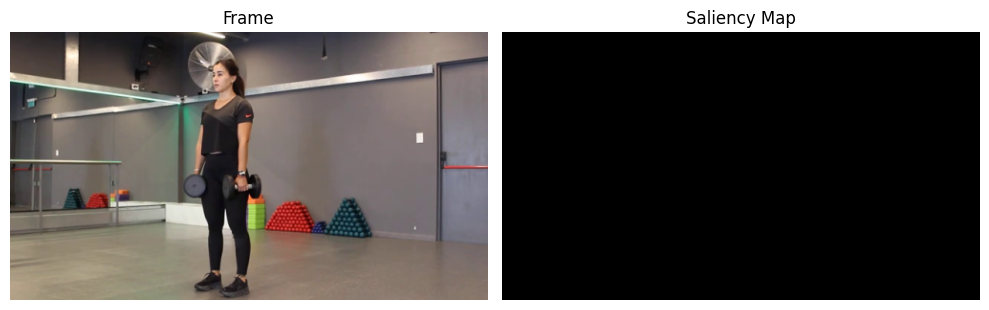

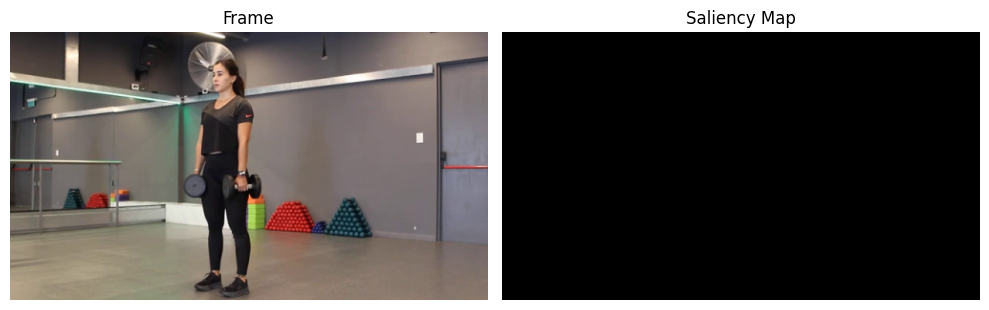

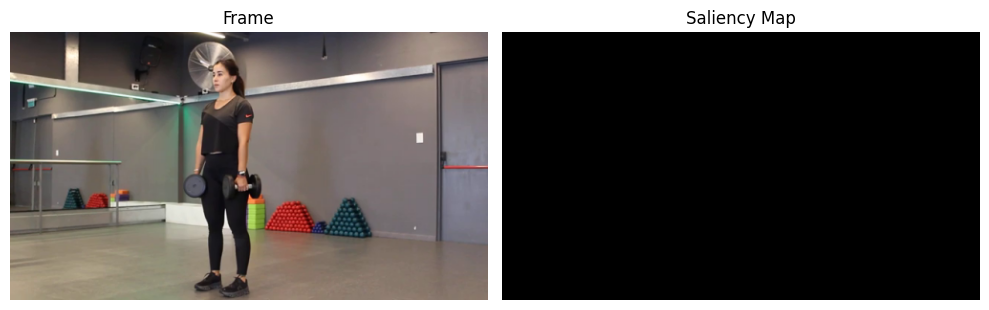

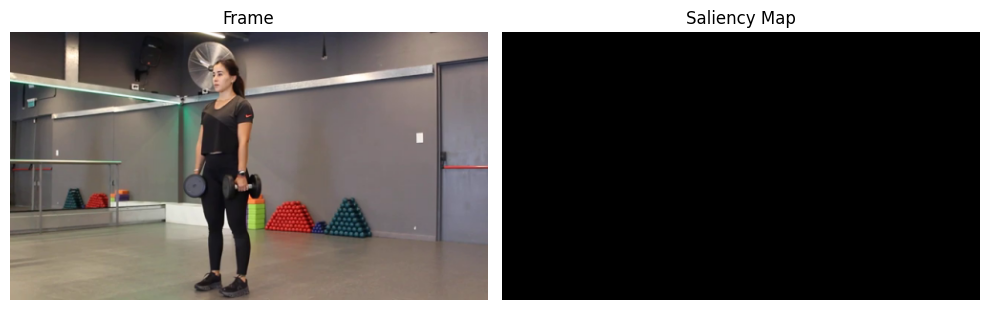

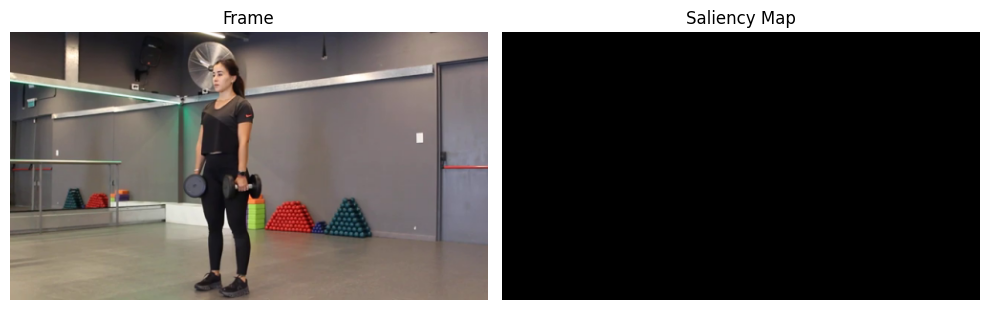

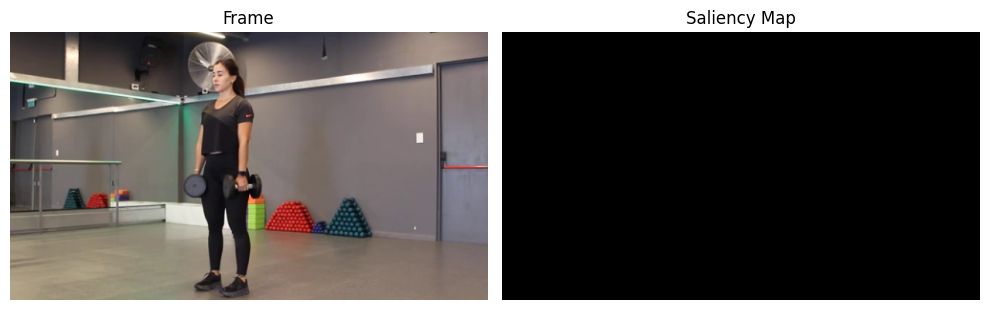

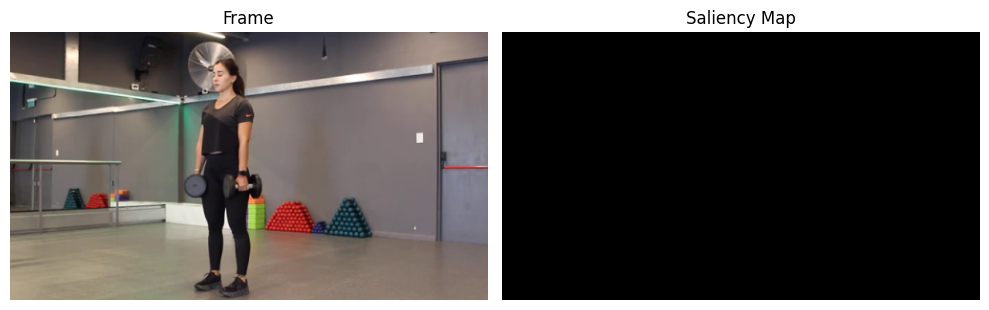

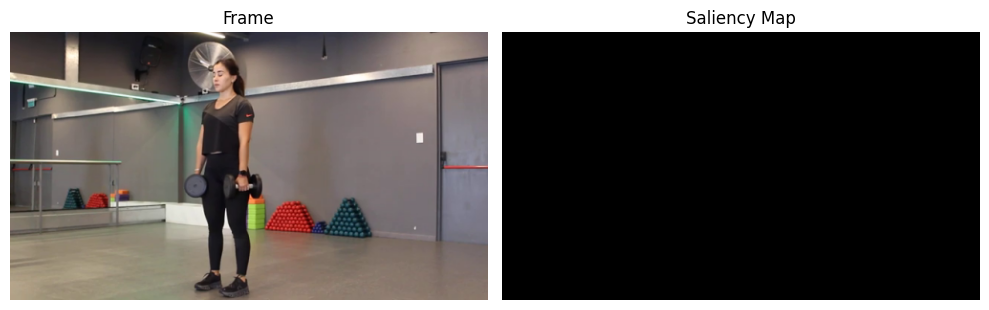

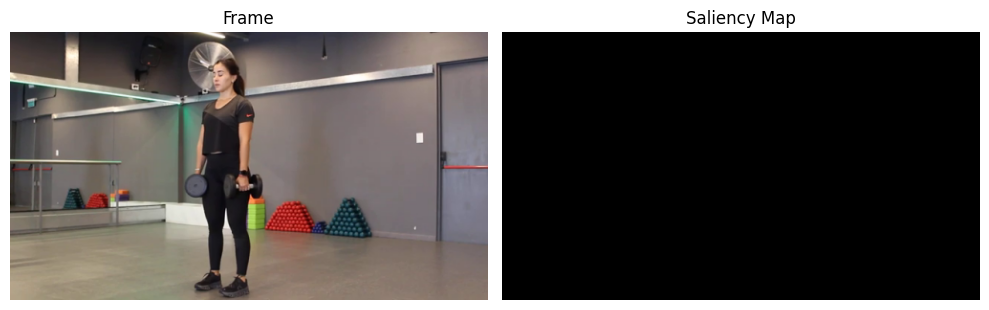

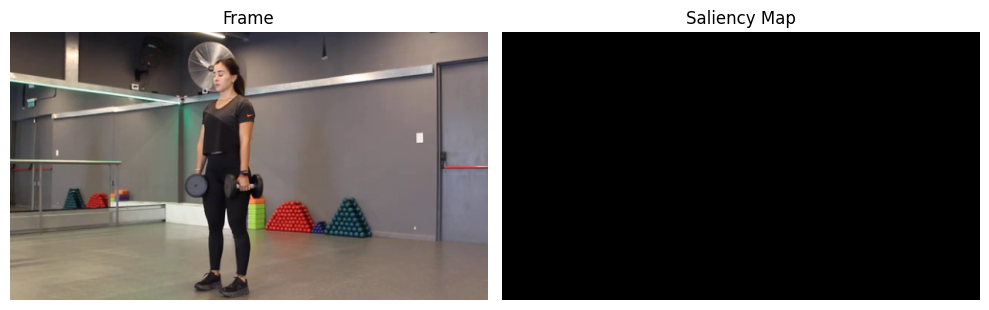

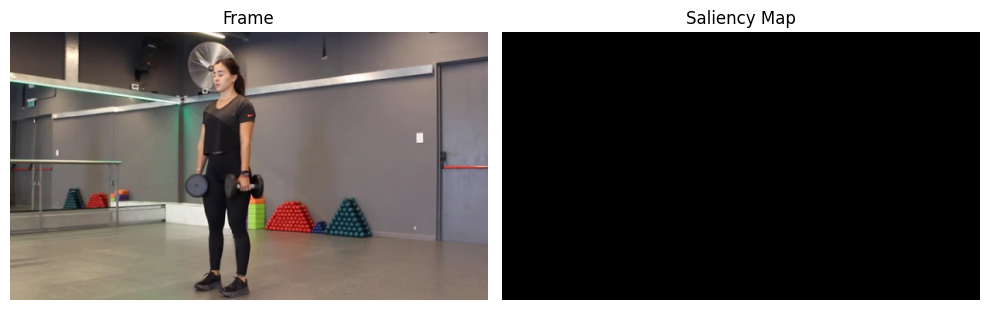

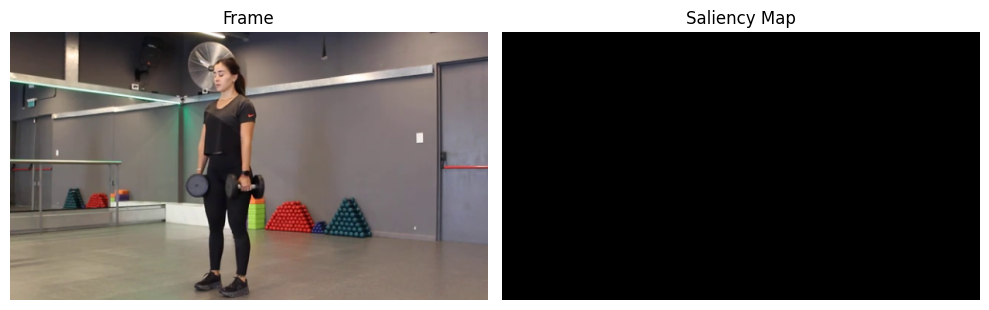

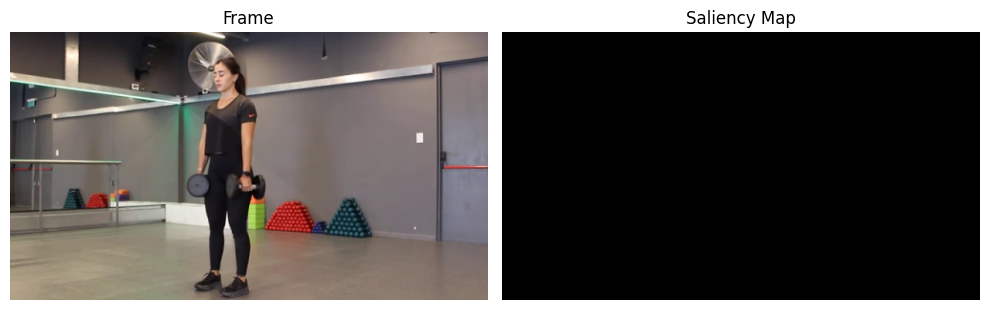

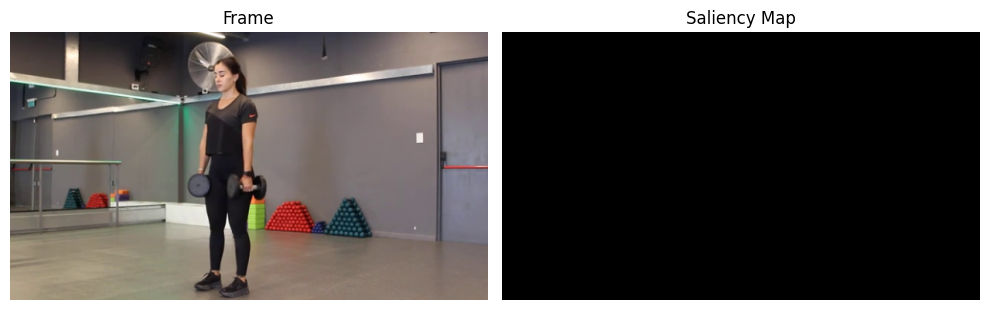

In [10]:
def show2(fr, m):
    fig, axes = plt.subplots(1,2,figsize=(10,4))
    axes[0].imshow(cv2.cvtColor(fr, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Frame'); axes[0].axis('off')
    axes[1].imshow(m, cmap='gray')
    axes[1].set_title('Saliency Map'); axes[1].axis('off')
    plt.tight_layout(); plt.show()
flim, fridx = 30, 0
while fridx < flim:
    ret, fram = vidcap.read()
    if not ret:
        break
    fram = imutils.resize(fram, width=500)
    if dyn_sal is None:
        dyn_sal = cv2.saliency.MotionSaliencyBinWangApr2014_create()
        dyn_sal.setImagesize(fram.shape[1], fram.shape[0]); dyn_sal.init()
    g = cv2.cvtColor(fram, cv2.COLOR_BGR2GRAY)
    ok, sal = dyn_sal.computeSaliency(g)
    sal = (sal * 255).astype(np.uint8)
    show2(fram, sal)
    fridx += 1
vidcap.release()

In [11]:
img2 = cv2.cvtColor(cv2.imread(IMG_PATH), cv2.COLOR_BGR2RGB)
px = img2.reshape((-1,3))

In [12]:
px = np.float32(px)

In [13]:
crit = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
segments = 4
_, seglabels, ctrs = cv2.kmeans(px, segments, None, crit, 10, cv2.KMEANS_RANDOM_CENTERS)

In [14]:
ctrs = np.uint8(ctrs)
segimg = ctrs[seglabels.flatten()]
segimg = segimg.reshape(img2.shape)

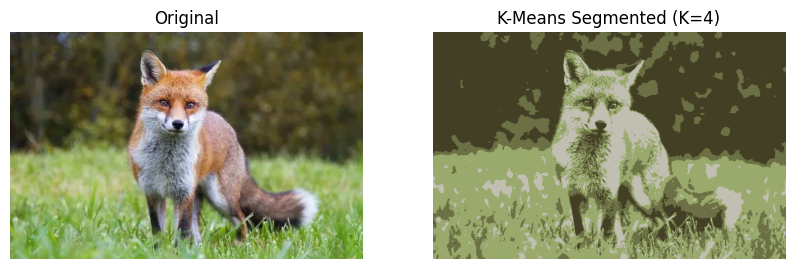

In [15]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title('Original'); plt.imshow(img2); plt.axis('off')
plt.subplot(1,2,2); plt.title('K-Means Segmented (K=4)'); plt.imshow(segimg); plt.axis('off')
plt.show()

In [16]:
g_img = cv2.imread(IMG_PATH)
g_g = cv2.cvtColor(g_img, cv2.COLOR_BGR2GRAY)
g_g = cv2.resize(g_g, (100,100))

In [17]:
h1, w1 = g_g.shape
Gp = nx.Graph()

In [18]:
for a in range(h1):
    for b in range(w1):
        node = a*w1 + b
        Gp.add_node(node, intensity=int(g_g[a, b]))
        if b+1 < w1:
            nbr = a*w1 + (b+1)
            wt = np.exp(-abs(int(g_g[a, b]) - int(g_g[a, b+1]))/10)
            Gp.add_edge(node, nbr, weight=wt)
        if a+1 < h1:
            nbrd = (a+1)*w1 + b
            wt = np.exp(-abs(int(g_g[a, b]) - int(g_g[a+1, b]))/10)
            Gp.add_edge(node, nbrd, weight=wt)

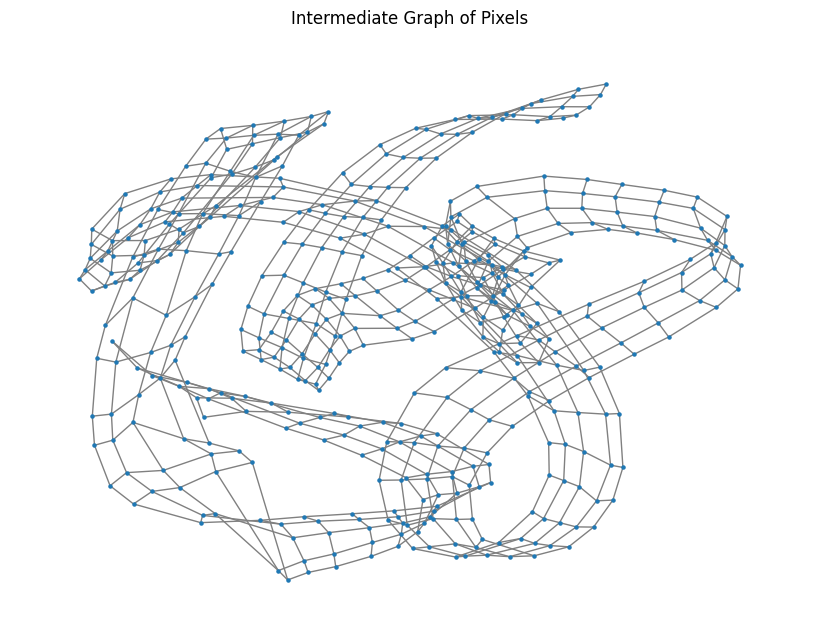

In [19]:
subnodes = list(Gp.nodes())[:500]
gsub = Gp.subgraph(subnodes)
plt.figure(figsize=(8,6))
pos = nx.spring_layout(gsub, seed=42)
nx.draw(gsub, pos, node_size=5, with_labels=False, edge_color='gray')
plt.title("Intermediate Graph of Pixels")
plt.show()

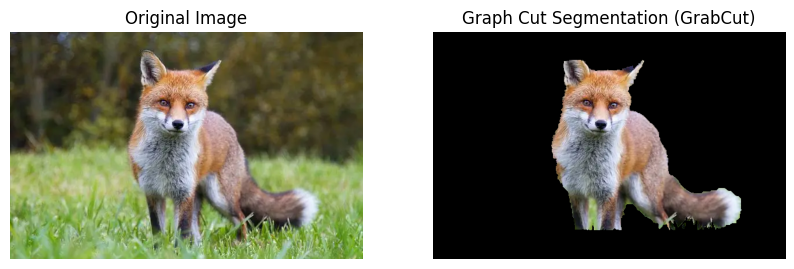

In [20]:
grabimg = cv2.imread(IMG_PATH)
mskgrab = np.zeros(grabimg.shape[:2], np.uint8)
bgd=zeros = np.zeros((1,65), np.float64); fgd=zeros = np.zeros((1,65), np.float64)
box = (50, 50, grabimg.shape[1]-100, grabimg.shape[0]-100)
cv2.grabCut(grabimg, mskgrab, box, bgd, fgd, 5, cv2.GC_INIT_WITH_RECT)
mask_ref = np.where((mskgrab==2)|(mskgrab==0), 0, 1).astype('uint8')
rescut = grabimg * mask_ref[:,:,np.newaxis]
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title('Original Image'); plt.imshow(cv2.cvtColor(grabimg, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.subplot(1,2,2); plt.title('Graph Cut Segmentation (GrabCut)'); plt.imshow(cv2.cvtColor(rescut, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.show()

In [21]:
import cv2